<a href="https://colab.research.google.com/github/kishore779/Pytorch_Programming/blob/main/02_neural_network_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02 Neural Network classification with PyTorch

In [83]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [84]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


In [85]:
len(X), len(y)

(1000, 1000)

In [86]:
print(f"First 5 samples : {X[:5]}")
print(f"First 5 labels : {y[:5]}")

First 5 samples : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels : [1 1 1 1 0]


In [87]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


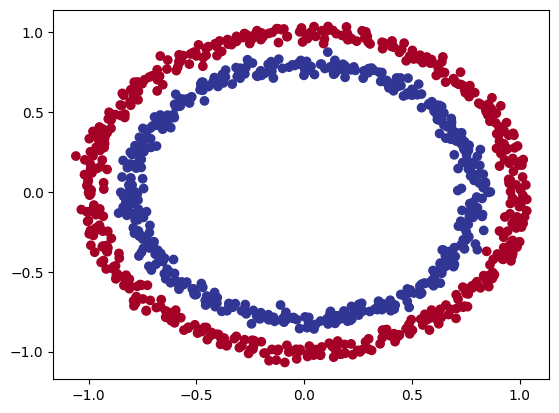

In [88]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [89]:
X.shape, y.shape

((1000, 2), (1000,))

##Turn data into tensor and split the data

In [90]:
import torch
torch.__version__

'2.9.0+cu126'

In [91]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [92]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [93]:
#Spilt the data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [94]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building a model

In [96]:
from sklearn import datasets

class CircularModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircularModelV0().to(device)
model_0

CircularModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [97]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## By using the Sequential module

 * model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0


In [98]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2060], device='cuda:0'))])

In [99]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')

## Set up a loss function and optimizer

In [100]:
##  loss_fn = nn.BCELoss()

loss_fn = nn.BCEWithLogitsLoss() # sigmoid fn activation

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [101]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## Training the model using the known steps from prev section

In [102]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [103]:
## use sigmoid activation fn

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [104]:
y_preds = torch.round(y_pred_probs)

y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

## Building a training and Testing Loop

In [105]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and acc
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  # optimizer zero_grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  ## testing
  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%")


Epoch:0 | Loss: 0.69569 | Acc: 50.00% | Test_loss: 0.69721 | Test_acc: 50.00%
Epoch:10 | Loss: 0.69403 | Acc: 50.00% | Test_loss: 0.69615 | Test_acc: 50.00%
Epoch:20 | Loss: 0.69343 | Acc: 46.00% | Test_loss: 0.69585 | Test_acc: 48.50%
Epoch:30 | Loss: 0.69321 | Acc: 49.00% | Test_loss: 0.69577 | Test_acc: 47.50%
Epoch:40 | Loss: 0.69312 | Acc: 49.50% | Test_loss: 0.69573 | Test_acc: 46.50%
Epoch:50 | Loss: 0.69308 | Acc: 50.38% | Test_loss: 0.69569 | Test_acc: 46.50%
Epoch:60 | Loss: 0.69306 | Acc: 50.50% | Test_loss: 0.69564 | Test_acc: 46.50%
Epoch:70 | Loss: 0.69305 | Acc: 50.50% | Test_loss: 0.69559 | Test_acc: 46.50%
Epoch:80 | Loss: 0.69304 | Acc: 50.75% | Test_loss: 0.69553 | Test_acc: 46.50%
Epoch:90 | Loss: 0.69303 | Acc: 50.38% | Test_loss: 0.69547 | Test_acc: 46.50%


In [106]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("its already there")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

its already there


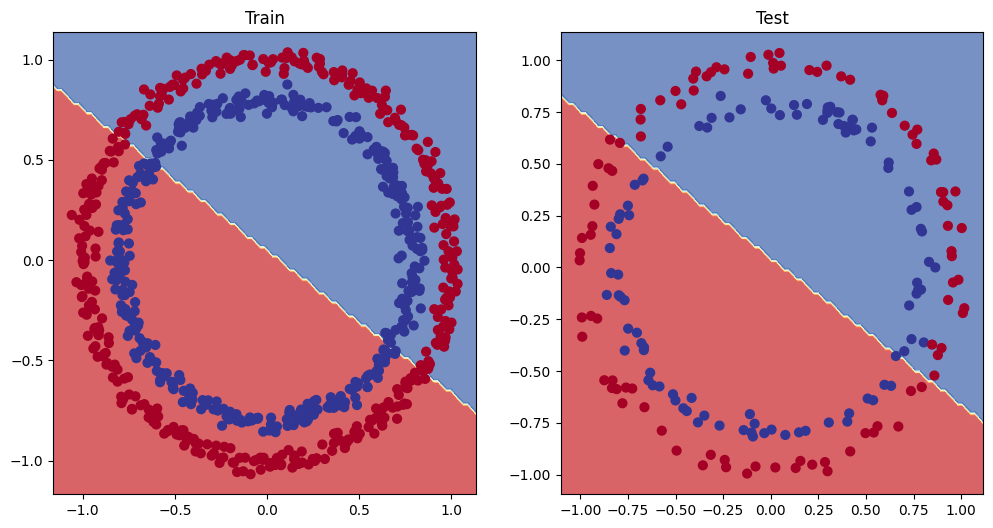

In [107]:
# plot decision boundry

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

##5.1 Preparing data to see if our model can fit a straight line

to troubleshoot the problem

In [108]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_reg = torch.arange(start,end,step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

print(len(X_reg))
X_reg[:5],y_reg[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [109]:
#crate terain and test

train_spilt = int(0.8 * len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_spilt],y_reg[:train_spilt]
X_test_reg, y_test_reg = X_reg[train_spilt:],y_reg[train_spilt:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

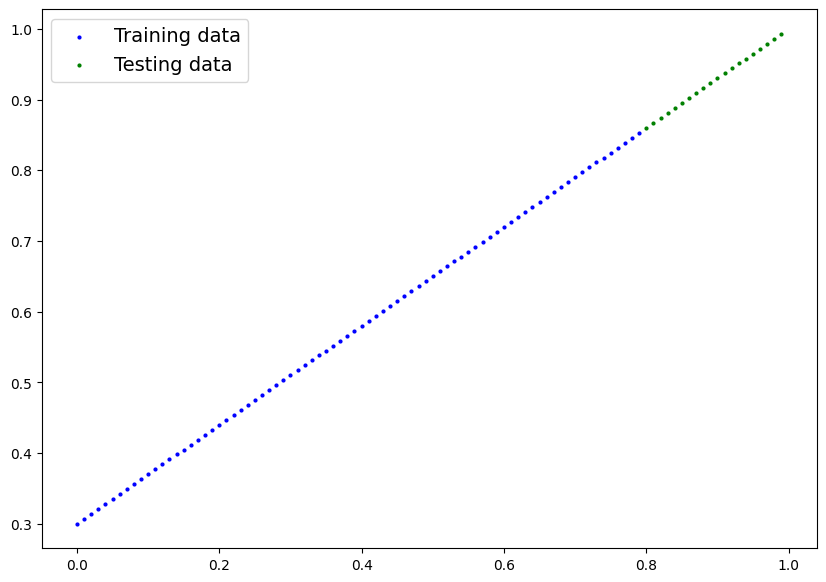

In [110]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

## 5.2 Adjusting the model_1 to fit the straight line

In [111]:
##same architecture as model_0 by nn.squential()

model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_1

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [112]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr = 0.01)

In [113]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):

  model_1.train()
  y_pred = model_1(X_train_reg)
  loss = loss_fn(y_pred, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test_reg)
    test_loss = loss_fn(test_pred, y_test_reg)
  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch:0 | Loss: 0.75986 | Test_loss: 0.91103
Epoch:100 | Loss: 0.02858 | Test_loss: 0.00081
Epoch:200 | Loss: 0.02533 | Test_loss: 0.00209
Epoch:300 | Loss: 0.02137 | Test_loss: 0.00305
Epoch:400 | Loss: 0.01964 | Test_loss: 0.00341
Epoch:500 | Loss: 0.01940 | Test_loss: 0.00387
Epoch:600 | Loss: 0.01903 | Test_loss: 0.00379
Epoch:700 | Loss: 0.01878 | Test_loss: 0.00381
Epoch:800 | Loss: 0.01840 | Test_loss: 0.00329
Epoch:900 | Loss: 0.01798 | Test_loss: 0.00360


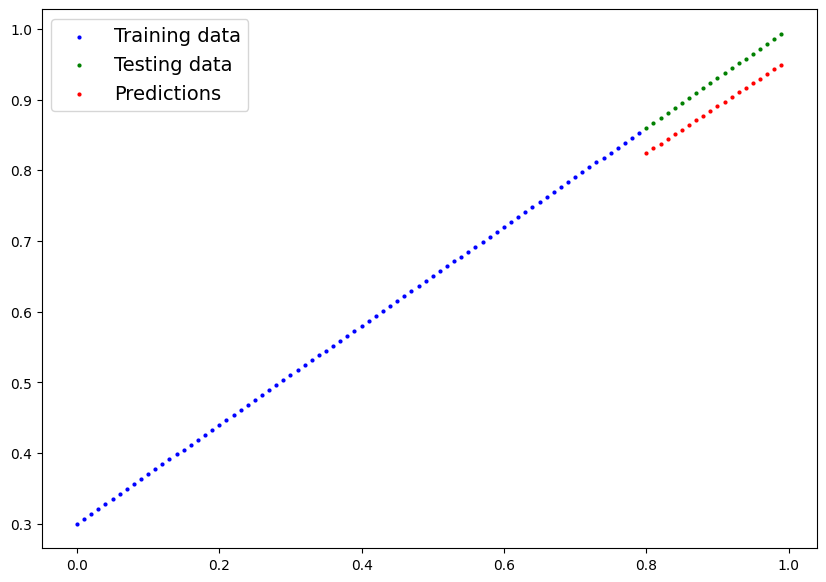

In [114]:
model_1.eval()
with torch.inference_mode():
  y_preds_ = model_1(X_test_reg)

  plot_predictions(train_data=X_train_reg.cpu(),
                   train_labels=y_train_reg.cpu(),
                   test_data=X_test_reg.cpu(),
                   test_labels=y_test_reg.cpu(),
                   predictions=y_preds_.cpu())

 ## By the non Linearity Funtions we use that can improve the accuracy

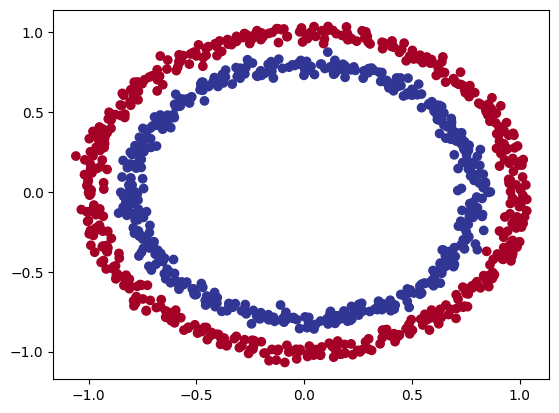

In [115]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [116]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## We build a model with ReLU function

In [117]:
## model with non-linearity

class CircularModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features =10, out_features =10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = CircularModelV2().to(device)
model_2

CircularModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [118]:
## loss fn and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

## Training and testing with ReLU

In [119]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred = test_preds)

  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:.5f}% | test_loss:{test_loss:.5f} | test_acc:{test_acc:.5f}%")

Epoch:0 | Loss:0.69295 | Acc:50.00000% | test_loss:0.69319 | test_acc:50.00000%
Epoch:100 | Loss:0.69115 | Acc:52.87500% | test_loss:0.69102 | test_acc:52.50000%
Epoch:200 | Loss:0.68977 | Acc:53.37500% | test_loss:0.68940 | test_acc:55.00000%
Epoch:300 | Loss:0.68795 | Acc:53.00000% | test_loss:0.68723 | test_acc:56.00000%
Epoch:400 | Loss:0.68517 | Acc:52.75000% | test_loss:0.68411 | test_acc:56.50000%
Epoch:500 | Loss:0.68102 | Acc:52.75000% | test_loss:0.67941 | test_acc:56.50000%
Epoch:600 | Loss:0.67515 | Acc:54.50000% | test_loss:0.67285 | test_acc:56.00000%
Epoch:700 | Loss:0.66659 | Acc:58.37500% | test_loss:0.66322 | test_acc:59.00000%
Epoch:800 | Loss:0.65160 | Acc:64.00000% | test_loss:0.64757 | test_acc:67.50000%
Epoch:900 | Loss:0.62362 | Acc:74.00000% | test_loss:0.62145 | test_acc:79.00000%


In [120]:
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [121]:
model_2.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  

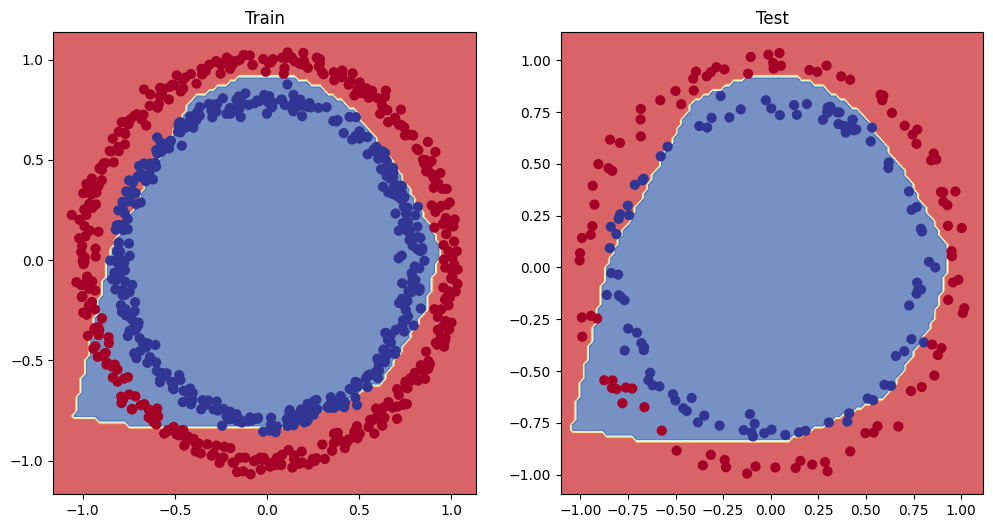

In [122]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test, y_test)

## Replicating non-linear activation functions

In [123]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [124]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

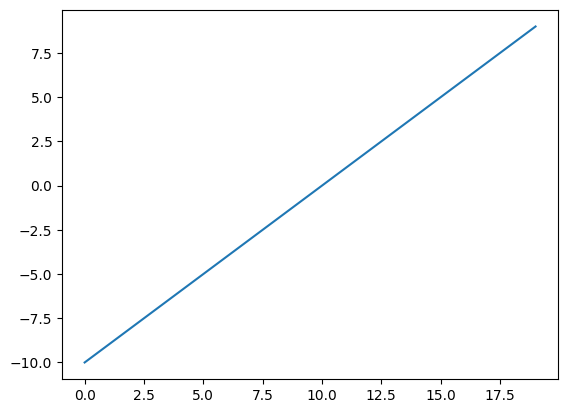

In [125]:
plt.plot(A);

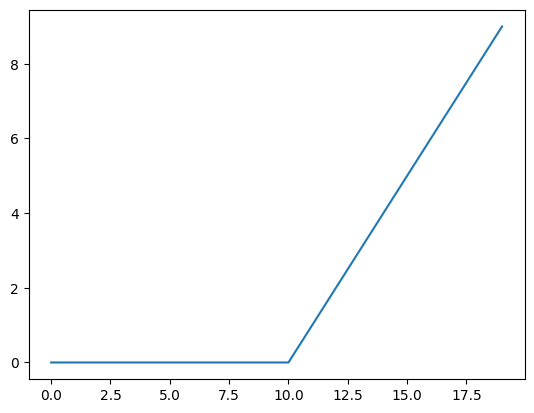

In [126]:
## by default torch.relu
plt.plot(torch.relu(A));

In [127]:
# by relu function on A
def relu(x):
  return torch.maximum(torch.tensor(0), x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

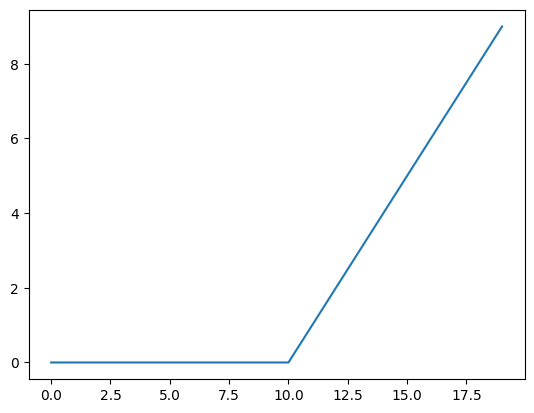

In [128]:
plt.plot(relu(A))

##  8. Putting it all together with a multi-class classification problem
* Binary -> cat or dog
* Multiclass -> cat or dog or chick

### 8.1 Creating a toy dataset

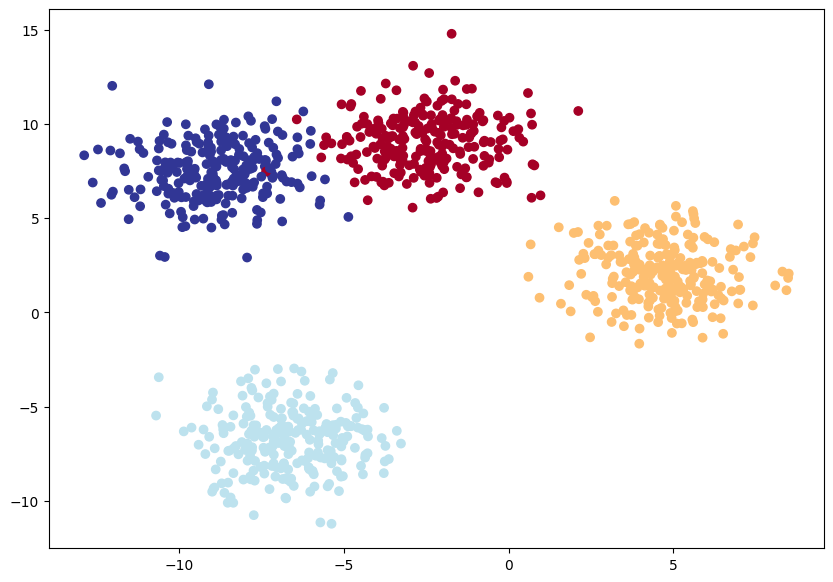

In [144]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

Num_classes = 4
Num_features = 2
Random_seed = 42

# Make the MC dataset
X_blob, y_blob = make_blobs(n_samples =1000,
                            n_features=Num_features,
                            centers=Num_classes,
                            cluster_std=1.5,
                            random_state=Random_seed)

#turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#spilting the data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=42
)

#visualize
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a Multiclass Model

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [146]:
# Build a MC model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)
model_3 = BlobModel(input_features=Num_features,
                    output_features=Num_classes,
                    hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [147]:
X_blob_train.shape

torch.Size([800, 2])

In [148]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

In [149]:
y_blob_train.unique()

tensor([0, 1, 2, 3])

### 8.3 Creating a loss fn and optimizer

In [162]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.001)

### 8.4 Predicting prob for a multiclass pytorch model

logits(raw output of the model) -> predictions(use `torch.softmax`) -> prediction_label(take the argmax pred prebs)

we need to convert it

In [163]:
next(model_3.parameters()).device

device(type='cuda', index=0)

In [164]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test.to(device))
y_logits[:10]

tensor([[-1.5542,  1.7984, -3.0659, -2.5587],
        [-0.1340, -2.3585, -2.3947,  0.1084],
        [ 0.1711, -0.2470,  0.3359, -0.0320],
        [-0.9659,  1.3479, -1.6200, -1.5903],
        [ 0.0162, -2.1152, -3.5049, -0.7106],
        [-0.2056, -2.7242, -2.8085,  0.1473],
        [ 0.0799, -0.3315,  0.2349, -0.0386],
        [ 0.0231, -2.3996, -2.9119, -0.3001],
        [ 0.1487, -0.3313,  0.3018, -0.0904],
        [ 0.0650, -2.3815, -3.0008, -0.3979]], device='cuda:0')

In [165]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

tensor([[0.0332, 0.9474, 0.0073, 0.0121],
        [0.4021, 0.0435, 0.0419, 0.5124],
        [0.2737, 0.1802, 0.3227, 0.2234],
        [0.0822, 0.8311, 0.0427, 0.0440],
        [0.6129, 0.0727, 0.0181, 0.2963]], device='cuda:0')


In [166]:
y_pred_probs[0]

tensor([0.0332, 0.9474, 0.0073, 0.0121], device='cuda:0')

In [167]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [168]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 0, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 0, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 0,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 0, 0, 3, 3, 0, 2, 1, 3, 0, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [169]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training and testing loop

In [170]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train, y_train = X_blob_train.to(device), y_blob_train.to(device)
X_test, y_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits =model_3(X_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%")


Epoch:0 | Loss: 0.63879 | Acc: 96.88% | Test_loss: 0.67833 | Test_acc: 97.00%
Epoch:10 | Loss: 0.63630 | Acc: 96.88% | Test_loss: 0.67576 | Test_acc: 97.00%
Epoch:20 | Loss: 0.63382 | Acc: 96.88% | Test_loss: 0.67320 | Test_acc: 97.00%
Epoch:30 | Loss: 0.63135 | Acc: 96.88% | Test_loss: 0.67065 | Test_acc: 97.00%
Epoch:40 | Loss: 0.62889 | Acc: 97.12% | Test_loss: 0.66811 | Test_acc: 97.00%
Epoch:50 | Loss: 0.62643 | Acc: 97.12% | Test_loss: 0.66557 | Test_acc: 97.50%
Epoch:60 | Loss: 0.62399 | Acc: 97.25% | Test_loss: 0.66304 | Test_acc: 97.50%
Epoch:70 | Loss: 0.62156 | Acc: 97.25% | Test_loss: 0.66052 | Test_acc: 97.50%
Epoch:80 | Loss: 0.61913 | Acc: 97.62% | Test_loss: 0.65801 | Test_acc: 97.50%
Epoch:90 | Loss: 0.61672 | Acc: 97.75% | Test_loss: 0.65549 | Test_acc: 97.50%


### 8.6 Making and evaluate the model with PyTorch multi-class model

In [171]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test)

y_logits[:10]

tensor([[-1.5583,  1.9325, -3.1613, -2.6929],
        [-0.1326, -2.4940, -2.4991,  0.1649],
        [ 0.1631, -0.2506,  0.3572, -0.0366],
        [-0.9829,  1.4442, -1.6628, -1.6730],
        [ 0.0775, -2.1649, -3.6741, -0.7692],
        [-0.2069, -2.8822, -2.9300,  0.2188],
        [ 0.0714, -0.3371,  0.2562, -0.0410],
        [ 0.0733, -2.5186, -3.0434, -0.3057],
        [ 0.1318, -0.3549,  0.3172, -0.1015],
        [ 0.1248, -2.4967, -3.1353, -0.4152]], device='cuda:0')

In [172]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.0291, 0.9556, 0.0059, 0.0094],
        [0.3945, 0.0372, 0.0370, 0.5313],
        [0.2707, 0.1790, 0.3287, 0.2217],
        [0.0750, 0.8494, 0.0380, 0.0376],
        [0.6416, 0.0681, 0.0151, 0.2752],
        [0.3752, 0.0258, 0.0246, 0.5743],
        [0.2659, 0.1767, 0.3198, 0.2376],
        [0.5544, 0.0415, 0.0246, 0.3795],
        [0.2770, 0.1703, 0.3334, 0.2194],
        [0.5904, 0.0429, 0.0227, 0.3440]], device='cuda:0')

In [173]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 0, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 0, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 0,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 0, 2, 1, 3, 0, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [174]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

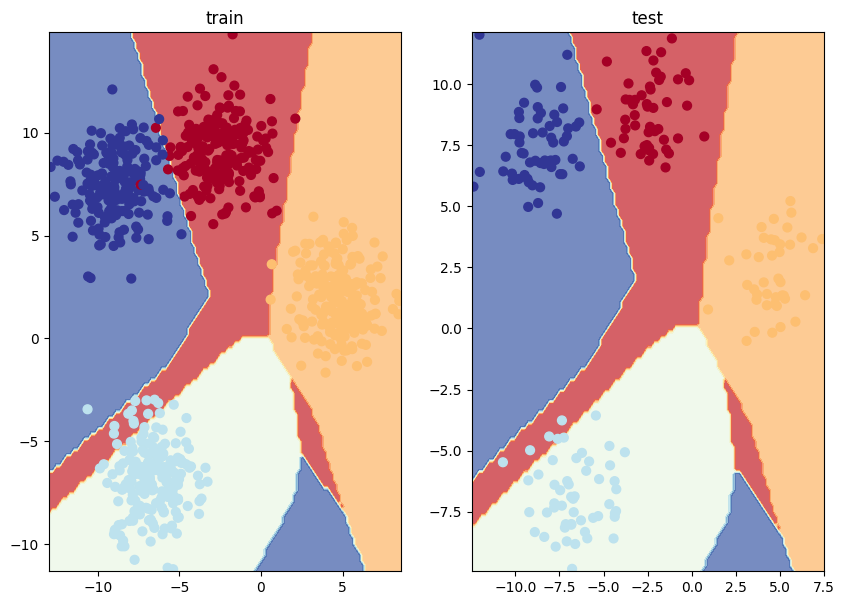

In [178]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

## 9. Evaluating the classification model

* Accuracy
* Precision
* Recall
* F1 score

In [179]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.8 MB/s eta 0:00:00


In [180]:
from torchmetrics import Precision, Recall, F1Score, Accuracy

In [182]:
torch_acc = Accuracy(task='multiclass', num_classes=Num_classes).to(device)
torch_acc(y_preds, y_test)

tensor(0.9750, device='cuda:0')